In [601]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

In [602]:
dataset_list = {
    "narrativeqa": "NarrativeQA",
    "qasper": "Qasper",
    "multifieldqa_en": "MFQA",
    "hotpotqa": "HotpotQA",
    "2wikimqa": "2WikiMQA",
    "musique": "MuSiQue",
    "gov_report": "GovReport",
    "qmsum": "QMSum",
    "multi_news": "MultiNews",
    "triviaqa": "TriviaQA",
    "samsum": "SAMSum",
    "passage_count": "PCount",
    "passage_retrieval_en": "PRetrieval",
}

colors = {
    "teal": "#4E79A7",
    "teal_light": "#A0CBE8",
    "orange": "#F28E2B",
    "orange_light": "#FFBE7D",
    "green": "#59A14F",
    "green_light": "#8CD17D",
    "gold": "#B6992D",
    "gold_light": "#F1CE63",
    "turquoise": "#499894",
    "turquoise_light": "#86BCB6",
    "red": "#E15759",
    "red_light": "#FF9D9A",
    "dark": "#79706E",
    "dark_light": "#BAB0AC",
    "pink": "#D37295",
    "pink_light": "#FABFD2",
    "purple": "#B07AA1",
    "purple_light": "#D4A6C8",
    "brown": "#9D7660",
    "brown_light": "#D7B5A6"
}


def load_latency_profile(path):
    model_name = None
    device_used = None
    cache_used = None

    output = {}
    dataset_names = []
    for json_file in glob.glob(path):
        with open(json_file, 'r') as f:
            data = json.load(f)

        if model_name is None:
            model_name = data["model_name"]
            device_used = data["device_used"]
            cache_used = data["cache_used"]

        # ensure correctness
        # assert data["model_name"] == model_name
        # assert data["device_used"] == device_used
        # assert data["cache_used"] == cache_used

        dataset_name = data["dataset_name"]
        if dataset_name not in dataset_list:
            continue
        results = data["results"]
        dataset_names.append(dataset_name)
        avg_latency_lb = 0
        avg_latency_ub = 0

        for result in results:
            cache_time = float(result["cache_time"])
            response_time = float(result["response_time"])

            avg_latency_lb += response_time
            avg_latency_ub += response_time + cache_time

        avg_latency_lb /= len(results)
        avg_latency_ub /= len(results)

        output[dataset_name] = {
            "latency_lb": avg_latency_lb,
            "latency_ub": avg_latency_ub
        }

    return output, dataset_list.keys()


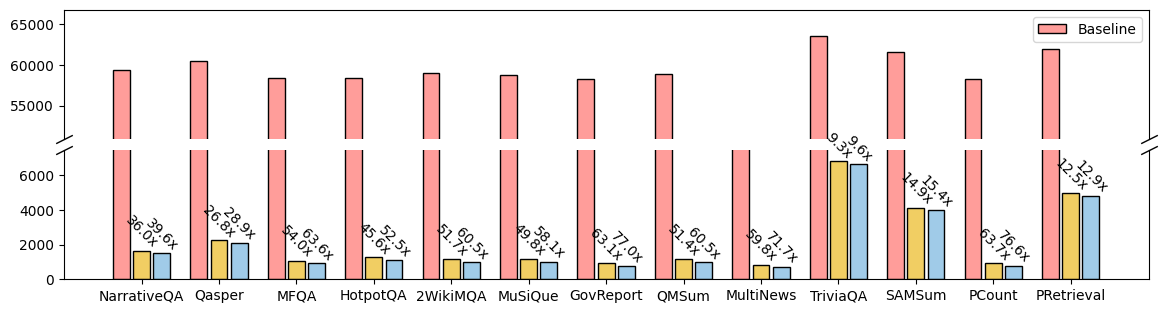

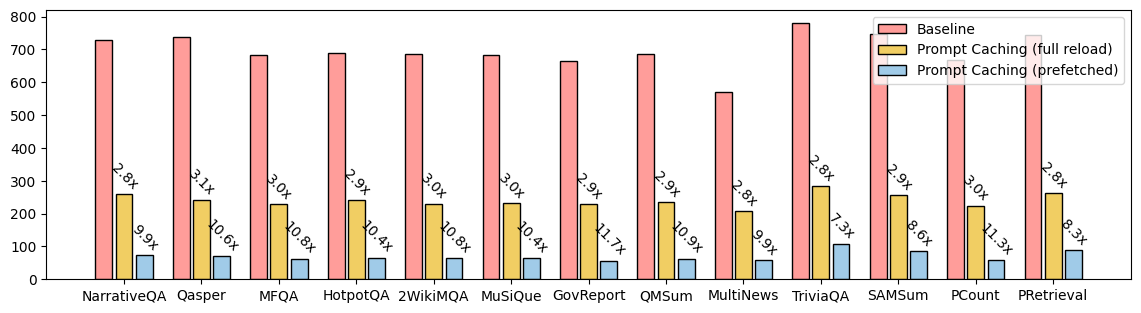

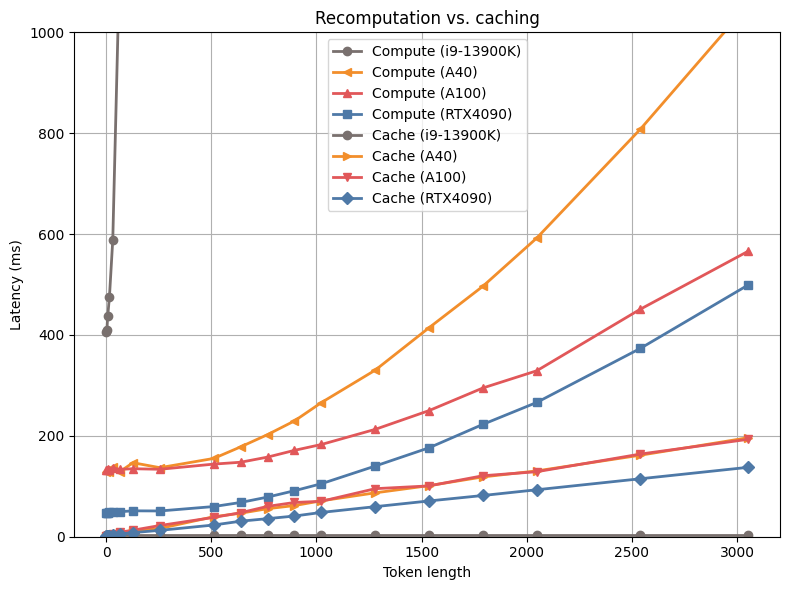

In [603]:



# 
# def plot_latency_cpu(model_name: str):
#     # get all files
#     path_gpu_no_cache = f"./benchmark/results_latency/{model_name}-cpu-no_cache-*.json"
#     path_gpu_cache = f"./benchmark/results_latency/{model_name}-cpu-cache-*.json"
# 
#     result_gpu_no_cache = load_latency_profile(path_gpu_no_cache)
#     result_gpu_cache = load_latency_profile(path_gpu_cache)
# 
#     dataset_names = result_gpu_no_cache.keys()
# 
#     # gather the 
#     latency_lb_gpu_no_cache = [result_gpu_no_cache[dataset_name]["latency_lb"] for dataset_name in dataset_names]
#     latency_ub_gpu_cache = [result_gpu_cache[dataset_name]["latency_ub"] for dataset_name in dataset_names]
#     latency_lb_gpu_cache = [result_gpu_cache[dataset_name]["latency_lb"] for dataset_name in dataset_names]
# 
#     # Sample data
#     n = len(dataset_names)  # Number of groups
#     labels = dataset_names
#     values_1 = latency_lb_gpu_no_cache  #np.random.randint(1, 10, n)  # Sample data for grey bars
#     values_2 = latency_ub_gpu_cache  #np.random.randint(1, 10, n)  # Sample data for blue bars
#     values_3 = latency_lb_gpu_cache  #np.random.randint(1, 10, n)  # Sample data for orange bars
# 
#     # Bar width, space within group, and space between groups
#     bar_width = 0.2
#     space = 0.05  # Space between bars within the same group
#     group_space = 0.3  # Space between different groups of bars
# 
#     # Compute the adjusted positions
#     index = np.arange(n) * (3 * bar_width + 2 * space + group_space)
#     plt.figure(figsize=(15, 4))
#     # Plotting the bars
#     plt.bar(index, values_1, bar_width, color='grey', alpha=0.7, label='No Caching')
#     plt.bar(index + bar_width + space, values_2, bar_width, color='blue', alpha=0.7,
#             label='Prompt Caching (full reload)')
#     plt.bar(index + 2 * bar_width + 2 * space, values_3, bar_width, color='orange', alpha=0.7,
#             label='Prompt Caching (prefetched)')
# 
#     # Adding the labels, title, and legend
#     plt.xlabel('Dataset', fontsize=14)
#     plt.ylabel('Latency (ms)', fontsize=14)
#     plt.title('Latency of GPU Inference', fontsize=16)
#     plt.xticks(index + bar_width + space, labels, fontsize=12, rotation=45)  # Adjust the tick positions and font
#     plt.yticks(fontsize=12)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.legend(fontsize=12)
# 
#     # Displaying the plot
#     plt.tight_layout()
#     plt.show()

def auto_mean(results):
    slots = {}

    for r in results:

        seq_len_str = str(r['seq_len'])
        if seq_len_str in slots:
            slots[seq_len_str].append(r['time'])
        else:
            slots[seq_len_str] = [r['time']]
    results = []
    for k in slots:
        slots[k] = sum(slots[k]) / len(slots[k])
        results.append({
            'seq_len': int(k),
            'time': slots[k]
        })

    return results


def plot_critical_point(model_name: str):
    path_cpu_re = f"./benchmark/results_latency/13900k-cpu-{model_name}-critical_point-recomputation.json"

    path_a40_re = f"./benchmark/results_latency/a40-{model_name}-critical_point-recomputation.json"
    path_a40_mm = f"./benchmark/results_latency/a40-{model_name}-critical_point-upload.json"
    path_a100_re = f"./benchmark/results_latency/a100-{model_name}-critical_point-recomputation.json"
    path_a100_mm = f"./benchmark/results_latency/a100-{model_name}-critical_point-upload.json"
    path_rtx4090_re = f"./benchmark/results_latency/13900k-gpu-{model_name}-critical_point-recomputation.json"
    path_rtx4090_mm = f"./benchmark/results_latency/13900k-gpu-{model_name}-critical_point-upload.json"

    data_cpu_re = auto_mean(json.load(open(path_cpu_re, 'r'))['results'])[1:20]
    data_a40_re = auto_mean(json.load(open(path_a40_re, 'r'))['results'])[1:20]
    data_a40_mm = auto_mean(json.load(open(path_a40_mm, 'r'))['results'])[1:20]
    data_a100_re = auto_mean(json.load(open(path_a100_re, 'r'))['results'])[1:20]
    data_a100_mm = auto_mean(json.load(open(path_a100_mm, 'r'))['results'])[1:20]
    data_rtx4090_re = auto_mean(json.load(open(path_rtx4090_re, 'r'))['results'])[1:20]
    data_rtx4090_mm = auto_mean(json.load(open(path_rtx4090_mm, 'r'))['results'])[1:20]

    x = [int(x['seq_len']) for x in data_a40_re]

    # Sample data

    colors = {
        "teal": "#4E79A7",
        "teal_light": "#A0CBE8",
        "orange": "#F28E2B",
        "orange_light": "#FFBE7D",
        "green": "#59A14F",
        "green_light": "#8CD17D",
        "gold": "#B6992D",
        "gold_light": "#F1CE63",
        "turquoise": "#499894",
        "turquoise_light": "#86BCB6",
        "red": "#E15759",
        "red_light": "#FF9D9A",
        "dark": "#79706E",
        "dark_light": "#BAB0AC",
        "pink": "#D37295",
        "pink_light": "#FABFD2",
        "purple": "#B07AA1",
        "purple_light": "#D4A6C8",
        "brown": "#9D7660",
        "brown_light": "#D7B5A6"
    }

    # Create the figure and axes
    plt.figure(figsize=(8, 6))
    plt.ylim(0, 1000)
    # Plotting the lines
    plt.plot(x, [float(x['time']) for x in data_cpu_re], '-o', label='Compute (i9-13900K)', color=colors['dark'],
             linewidth=2, markersize=6)

    plt.plot(x, [float(x['time']) for x in data_a40_re], '-<', label='Compute (A40)', color=colors['orange'], linewidth=2,
             markersize=6)

    plt.plot(x, [float(x['time']) for x in data_a100_re], '-^', label='Compute (A100)', color=colors['red'], linewidth=2,
             markersize=6)
    plt.plot(x, [float(x['time']) for x in data_rtx4090_re], '-s', label='Compute (RTX4090)', color=colors['teal'], linewidth=2,
             markersize=6)

    plt.plot(x, [4.221] * len(data_cpu_re), '-o', label='Cache (i9-13900K)', color=colors['dark'], linewidth=2,
             markersize=6)

    plt.plot(x, [float(x['time']) for x in data_a40_mm], '->', label='Cache (A40)', color=colors['orange'], linewidth=2,
             markersize=6)
    plt.plot(x, [float(x['time']) for x in data_a100_mm], '-v', label='Cache (A100)', color=colors['red'], linewidth=2,
             markersize=6)
    plt.plot(x, [float(x['time']) for x in data_rtx4090_mm], '-D', label='Cache (RTX4090)', color=colors['teal'], linewidth=2,
             markersize=6)

    # Adding titles, labels, and legend
    plt.title('Recomputation vs. caching')
    plt.xlabel('Token length')
    plt.ylabel('Latency (ms)')
    plt.legend()

    # Displaying the plot
    plt.grid(True)  # Optional: Adds a grid for better readability
    plt.tight_layout()
    plt.show()


def memory_pressure():
    model_factors = {
        "bert": 12 * 768 * 2,
        "falcon-1b": 24 * 2048 * 2,
        "llama-7b": 32 * 4096 * 2,
        "llama-13b": 40 * 5120 * 2,
        "mpt-30b": 48 * 7168 * 2,
        "falcon-40b": 60 * 8192 * 2,
        "llama-70b": 80 * 8192 * 2,
    }

    x = list(map(lambda x: x * 64, range(1, 100)))
    plt.figure(figsize=(8, 6))

    for model in model_factors:
        y = list(map(lambda x: x * model_factors[model] * 4 / 1024 / 1024, x))
        plt.plot(x, y, label=model, linewidth=2, markersize=4)

    # 
    # # Plotting the lines
    # plt.plot(x, time_re_13b, '-o', label='Recomputation (13B)', color='blue', linewidth=2, markersize=4)
    # plt.plot(x, time_up_13b, '-o', label='Caching (13B)', color='green', linewidth=2, markersize=4)
    # plt.plot(x, time_re_7b, '-o', label='Recomputation (7B)', color='orange', linewidth=2, markersize=4)
    # plt.plot(x, time_up_7b, '-o', label='Caching (7B)', color='red', linewidth=2, markersize=4)

    # Adding titles, labels, and legend
    plt.title("Memory pressure")
    plt.xlabel('Token length')
    plt.ylabel('MB')
    plt.legend()

    # Displaying the plot
    plt.grid(True)  # Optional: Adds a grid for better readability
    plt.tight_layout()
    plt.show()


def plot_latency_gpu(model_name: str):
    # get all files
    path_gpu_no_cache = f"./benchmark/results_latency/13900k-{model_name}-gpu-no_cache-*.json"
    path_gpu_cache = f"./benchmark/results_latency/13900k-{model_name}-gpu-cache-*.json"

    result_gpu_no_cache, dataset_names = load_latency_profile(path_gpu_no_cache)
    result_gpu_cache, _ = load_latency_profile(path_gpu_cache)

    dataset_display_names = [dataset_list[dataset_name] for dataset_name in dataset_names]
    # gather the 
    latency_lb_gpu_no_cache = [result_gpu_no_cache[dataset_name]["latency_lb"] for dataset_name in dataset_names]
    latency_ub_gpu_cache = [result_gpu_cache[dataset_name]["latency_ub"] for dataset_name in dataset_names]
    latency_lb_gpu_cache = [result_gpu_cache[dataset_name]["latency_lb"] for dataset_name in dataset_names]

    # Sample data
    n = len(dataset_names)  # Number of groups
    labels = dataset_display_names
    values_1 = latency_lb_gpu_no_cache  #np.random.randint(1, 10, n)  # Sample data for grey bars
    values_2 = latency_ub_gpu_cache  #np.random.randint(1, 10, n)  # Sample data for blue bars
    values_3 = latency_lb_gpu_cache  #np.random.randint(1, 10, n)  # Sample data for orange bars

    # Bar width, space within group, and space between groups
    bar_width = 0.25
    space = 0.05  # Space between bars within the same group
    group_space = 0.3  # Space between different groups of bars

    # Compute the adjusted positions
    index = np.arange(n) * (3 * bar_width + 2 * space + group_space)

    fig, ax = plt.subplots(figsize=(14, 3.5))

    # Plotting the bars
    bars_no_cache = ax.bar(index, values_1, bar_width, color=colors['red_light'], label='Baseline', edgecolor='black')
    bars_full_reload = ax.bar(index + bar_width + space, values_2, bar_width, color=colors['gold_light'],
                              label='Prompt Caching (full reload)', edgecolor='black')
    bars_prefetched = ax.bar(index + 2 * bar_width + 2 * space, values_3, bar_width, color=colors['teal_light'],
                             label='Prompt Caching (prefetched)', edgecolor='black')

    # Calculate and display reduction factors
    for idx, (bar_nc, bar_fr, bar_pf) in enumerate(zip(bars_no_cache, bars_full_reload, bars_prefetched)):
        reduction_full_reload = values_1[idx] / values_2[idx]
        reduction_prefetched = values_1[idx] / values_3[idx]

        height_fr = bar_fr.get_height()
        height_pf = bar_pf.get_height()

        ax.text(bar_fr.get_x() + bar_fr.get_width() / 2, height_fr + 5, f'{reduction_full_reload:.1f}x', ha='center',
                va='bottom', fontsize=10, color='black', rotation=-45)
        ax.text(bar_pf.get_x() + bar_pf.get_width() / 2, height_pf + 5, f'{reduction_prefetched:.1f}x', ha='center',
                va='bottom', fontsize=10, color='black', rotation=-45)

    # Adding the labels, title, and legend
    #plt.ylabel('Latency (ms)', fontsize=16)
    ax.set_xticks(index + bar_width + space, labels)  # Adjust the tick positions
    ax.legend()

    # Displaying the plot
    #plt.tight_layout()
    plt.show()


def plot_latency_cpu(model_name: str):
    # get all files
    path_gpu_no_cache = f"./benchmark/results_latency/13900k-{model_name}-cpu-no_cache-*.json"
    path_gpu_cache = f"./benchmark/results_latency/13900k-{model_name}-cpu-cache-*.json"

    result_gpu_no_cache, dataset_names = load_latency_profile(path_gpu_no_cache)
    result_gpu_cache, _ = load_latency_profile(path_gpu_cache)
    dataset_display_names = [dataset_list[dataset_name] for dataset_name in dataset_names]

    # gather the 
    latency_lb_gpu_no_cache = [result_gpu_no_cache[dataset_name]["latency_lb"] for dataset_name in dataset_names]
    latency_ub_gpu_cache = [result_gpu_cache[dataset_name]["latency_ub"] for dataset_name in dataset_names]
    latency_lb_gpu_cache = [result_gpu_cache[dataset_name]["latency_lb"] for dataset_name in dataset_names]

    # Sample data
    n = len(dataset_names)  # Number of groups
    labels = dataset_display_names
    values_1 = latency_lb_gpu_no_cache  #np.random.randint(1, 10, n)  # Sample data for grey bars
    values_2 = latency_ub_gpu_cache  #np.random.randint(1, 10, n)  # Sample data for blue bars
    values_3 = latency_lb_gpu_cache  #np.random.randint(1, 10, n)  # Sample data for orange bars

    # Bar width, space within group, and space between groups
    bar_width = 0.25
    space = 0.05  # Space between bars within the same group
    group_space = 0.3  # Space between different groups of bars

    # Compute the adjusted positions
    index = np.arange(n) * (3 * bar_width + 2 * space + group_space)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 3.5))
    fig.subplots_adjust(hspace=0.08)  # adjust space between axes

    # Set the limit for each subplot to break the y-axis
    ax1.set_ylim(0.8 * max(values_1), 1.05 * max(values_1))  # For larger values
    ax2.set_ylim(0, 1.1 * max(max(values_2), max(values_3)))  # For smaller values

    # Plotting the bars
    ax1.bar(index, values_1, bar_width, color=colors['red_light'], label='Baseline', edgecolor='black')

    bars_no_cache = ax2.bar(index, values_1, bar_width, color=colors['red_light'], label='Baseline', edgecolor='black')
    bars_full_reload = ax2.bar(index + bar_width + space, values_2, bar_width, color=colors['gold_light'],
                               label='Prompt Caching (full reload)', edgecolor='black')
    bars_prefetched = ax2.bar(index + 2 * bar_width + 2 * space, values_3, bar_width, color=colors['teal_light'],
                              label='Prompt Caching (prefetched)', edgecolor='black')
    # Turn off spines and tick labels for top subplot
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    #ax1.xaxis.tick_top()
    ax1.xaxis.set_ticks_position('none')

    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Calculate and display reduction factors
    for idx, (bar_nc, bar_fr, bar_pf) in enumerate(zip(bars_no_cache, bars_full_reload, bars_prefetched)):
        reduction_full_reload = values_1[idx] / values_2[idx]
        reduction_prefetched = values_1[idx] / values_3[idx]

        height_fr = bar_fr.get_height()
        height_pf = bar_pf.get_height()

        ax2.text(bar_fr.get_x() + bar_fr.get_width() / 2, height_fr + 5, f'{reduction_full_reload:.1f}x', ha='center',
                 va='bottom', fontsize=10, color='black', rotation=-45)
        ax2.text(bar_pf.get_x() + bar_pf.get_width() / 2, height_pf + 5, f'{reduction_prefetched:.1f}x', ha='center',
                 va='bottom', fontsize=10, color='black', rotation=-45)

    # Adding the labels, title, and legend
    #ax2.set_ylabel('Latency (ms)', fontsize=16)
    ax2.set_xticks(index + bar_width + space, labels)  # Adjust the tick positions
    ax1.legend()

    # Add break indicators
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    # Displaying the plot
    #plt.tight_layout()
    plt.show()


plot_latency_cpu("llama2-7b")
plot_latency_gpu("llama2-7b")
plot_critical_point("llama2-7b")
#memory_pressure()